In [11]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBallsCollisionDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss as mse_pytorch

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse as mse_esn

from itertools import product
from tqdm.notebook import tqdm_notebook

from models import VanilaRNN, GRU, LSTM, ESN, SeqESN, ParallelESN, GroupedESN

rpy.verbosity(0)

import pickle

# Importing data

In [24]:
batch_size = 32

train_data, test_data = ThreeBallsCollisionDataset.train_test_split('../data/raw/three-balls-collisions-limited-free-fall-tuning', test_frac=0.2, max_actions=200, free_fall_fraction=0.15)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  3637
train_test_split response: test fraction rounded to 0.19995601737313762 (3637 simulations)


# Hyperparameter Tuning for traditional RNNs

In [3]:
# dictionary to store the results
results = {}

results_file = 'results_dict_collisions.pkl'

try:
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [4]:
hidden_dims = [64, 96, 128, 192, 258]
nums_rnns = [1, 2, 3]
dropout_probs = [0, 0.1]

if 'vanilla_rnn' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['vanilla_rnn'] = []

for hidden_dim, num_rnns, dropout_prob in tqdm_notebook(product(hidden_dims, nums_rnns, dropout_probs)):
    set_included = False
    for val_set in results['vanilla_rnn']:
        if val_set['hidden_dim'] == hidden_dim and val_set['num_rnns'] == num_rnns and val_set['dropout_prob'] == dropout_prob:
            print(f'Value set already included: hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')
            set_included = True
            break

    if set_included:
        continue

    if num_rnns == 1 and dropout_prob != 0:
        continue

    print(f'Testing hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')

    vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=10000, input_dim=9, hidden_dim=hidden_dim, num_rnns=num_rnns, output_dim=48, dropout_prob=dropout_prob)
    test_loss = VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['vanilla_rnn'].append(
        {
            'hidden_dim': hidden_dim,
            'num_rnns': num_rnns,
            'dropout_prob': dropout_prob,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Value set already included: hidden_dim=64	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=3	 dropout_prob=0
Value 

In [5]:
len(results['vanilla_rnn'])

25

In [27]:
batch_size = 32

train_data_full, test_data_full = ThreeBallsCollisionDataset.train_test_split('../data/raw/three-balls-collisions-limited-free-fall', test_frac=0.2, max_actions=3000, free_fall_fraction=0.15)

train_dataloader_full = DataLoader(dataset=train_data_full, batch_size=batch_size)
test_dataloader_full = DataLoader(dataset=test_data_full, batch_size=batch_size)

Test size:  54811
train_test_split response: test fraction rounded to 0.1999985404496145 (54811 simulations)


# Vanila RNN

In [6]:
best_result_vanilla = min(results['vanilla_rnn'], key=lambda x: x['test_loss'])
best_result_vanilla

{'hidden_dim': 96,
 'num_rnns': 1,
 'dropout_prob': 0,
 'test_loss': tensor(0.0490, requires_grad=True)}

## One layer

Calculated loss:  tensor(0.0518, grad_fn=<PowBackward0>)


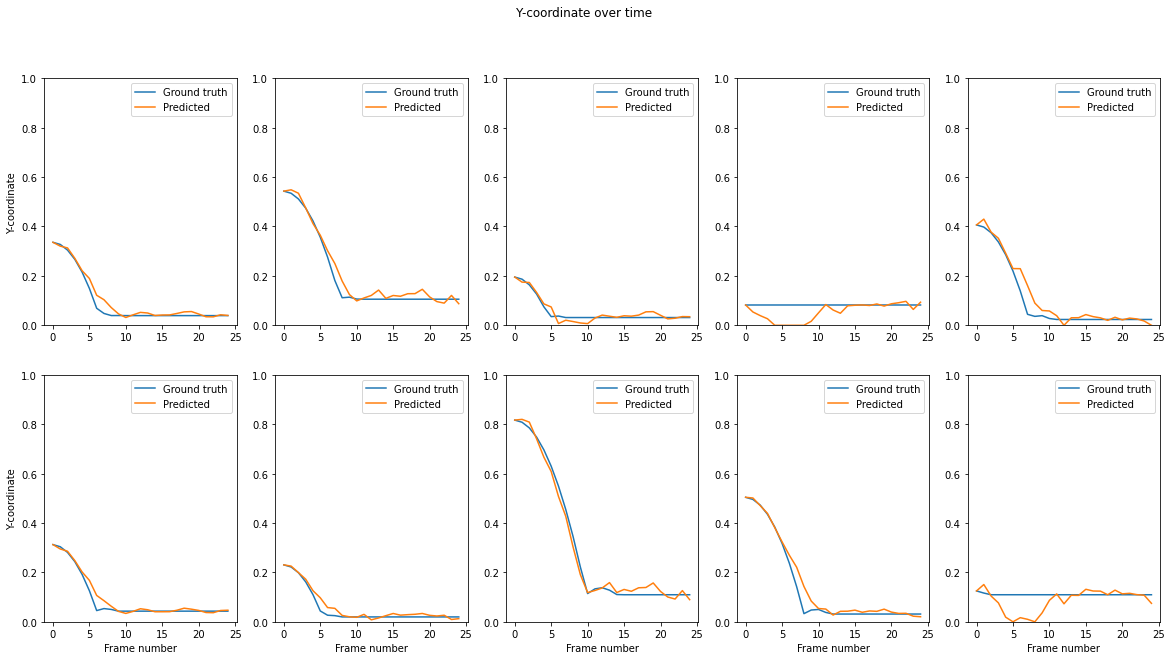

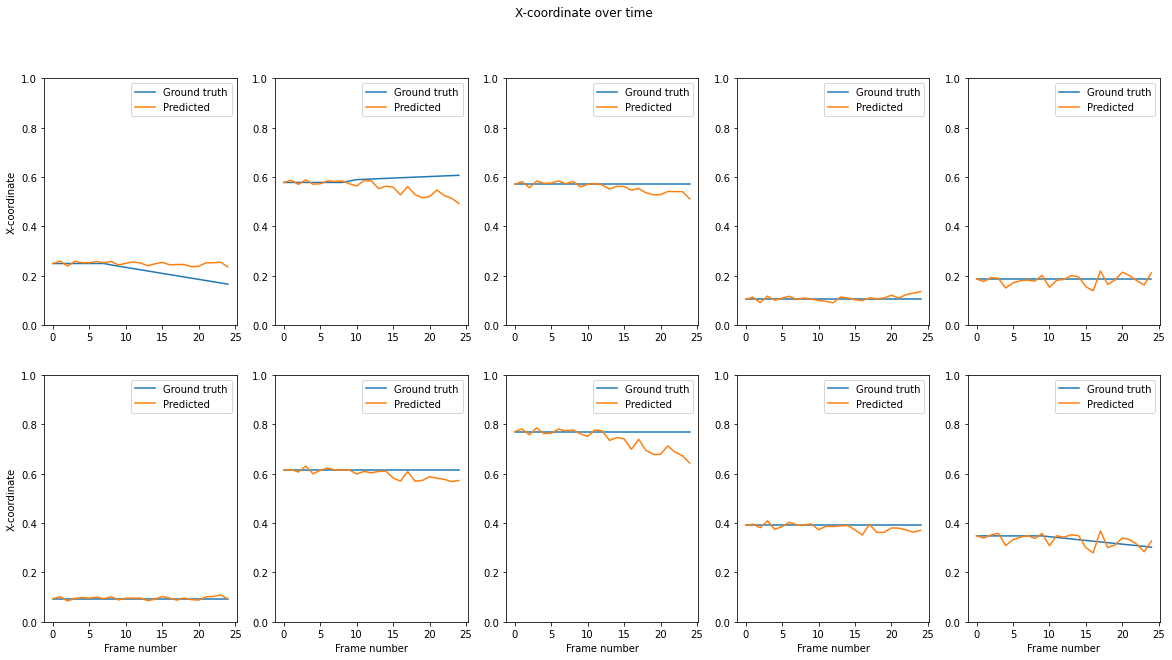

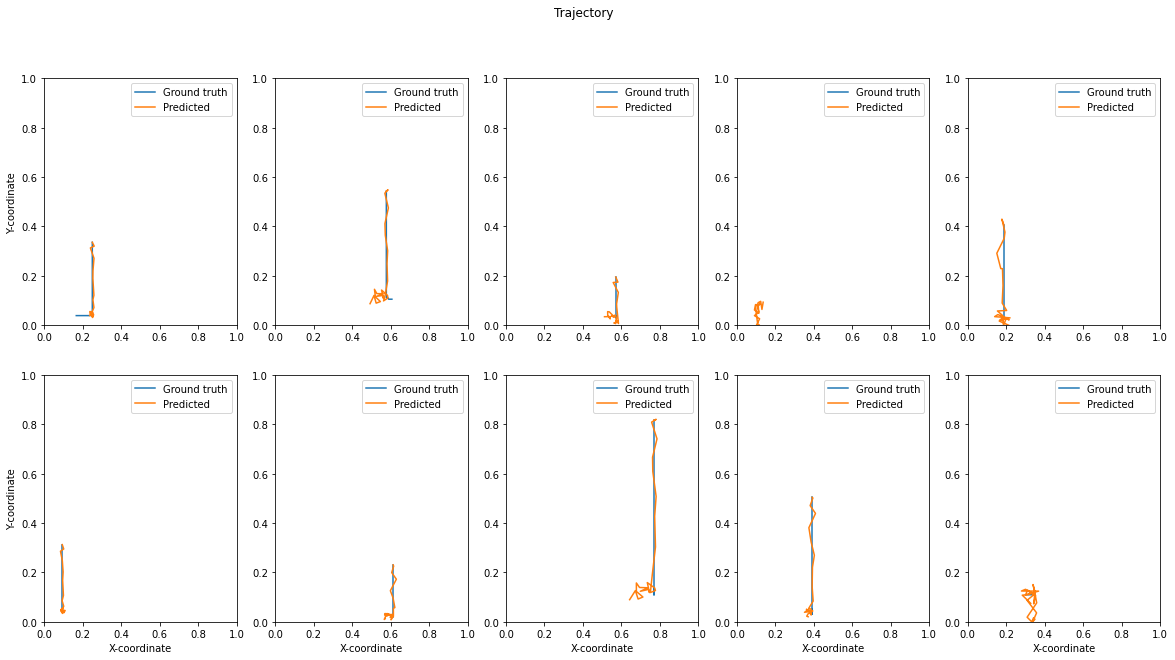

tensor(0.0518, grad_fn=<PowBackward0>)

In [16]:
vanila_rnn = VanilaRNN.train_model(num_epochs=50, learning_rate=0.03, train_dataloader=train_dataloader_full, error_threshold=1000, input_dim=9, hidden_dim=best_result_vanilla['hidden_dim'], num_rnns=best_result_vanilla['num_rnns'], output_dim=48, dropout_prob=best_result_vanilla['dropout_prob'])
VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## Two layers

VanilaRNN(
  (rnn): RNN(9, 96, num_layers=2, batch_first=True)
  (out): Linear(in_features=96, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 892.8650186788291
Epoch 1 complete. Training loss: 132.6536817587912
Epoch 2 complete. Training loss: 69.87360937753692
Epoch 3 complete. Training loss: 48.203750625252724
Epoch 4 complete. Training loss: 37.9601870829938
Epoch 5 complete. Training loss: 32.044047234696336
Epoch 6 complete. Training loss: 28.239305796450935
Epoch 7 complete. Training loss: 25.57559242588468
Epoch 8 complete. Training loss: 23.76839974708855
Epoch 9 complete. Training loss: 22.45420208160067
Epoch 10 complete. Training loss: 21.488322143268306
Epoch 11 complete. Training loss: 20.70924431324238
Epoch 12 complete. Training loss: 20.071939006622415
Epoch 13 complete. Training loss: 19.546001942711882
Epoch 14 complete. Training loss: 19.117384986951947
Epoch 15 complete. Training loss: 18.66624613458407
Epoch 16 complete. Training loss: 18.2508883304

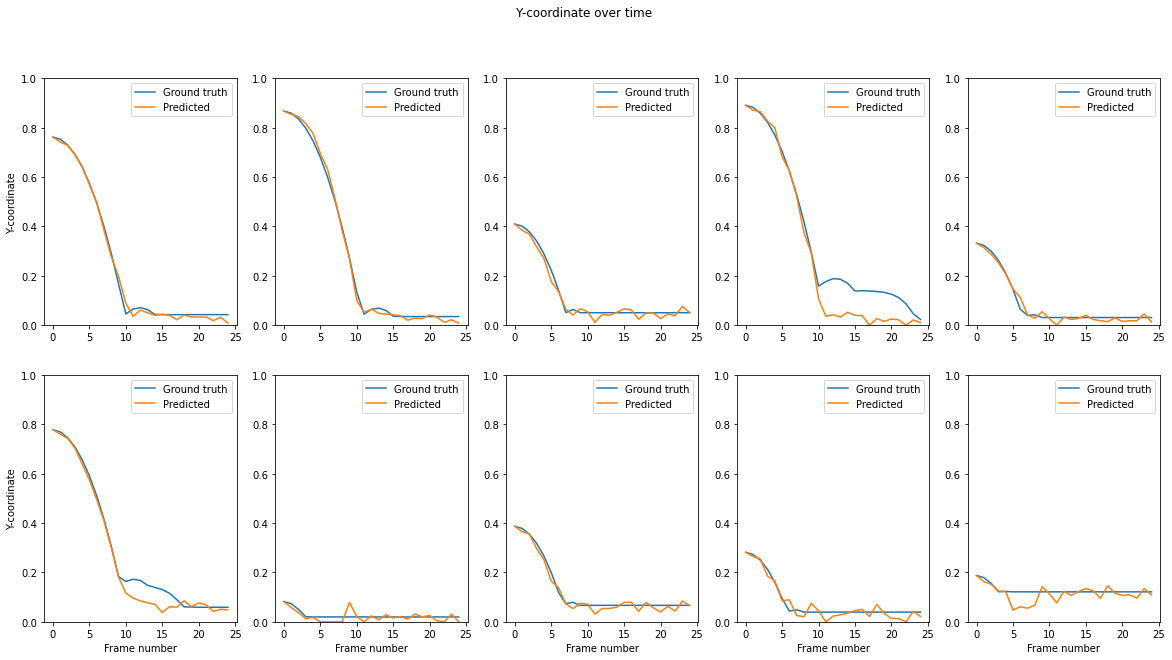

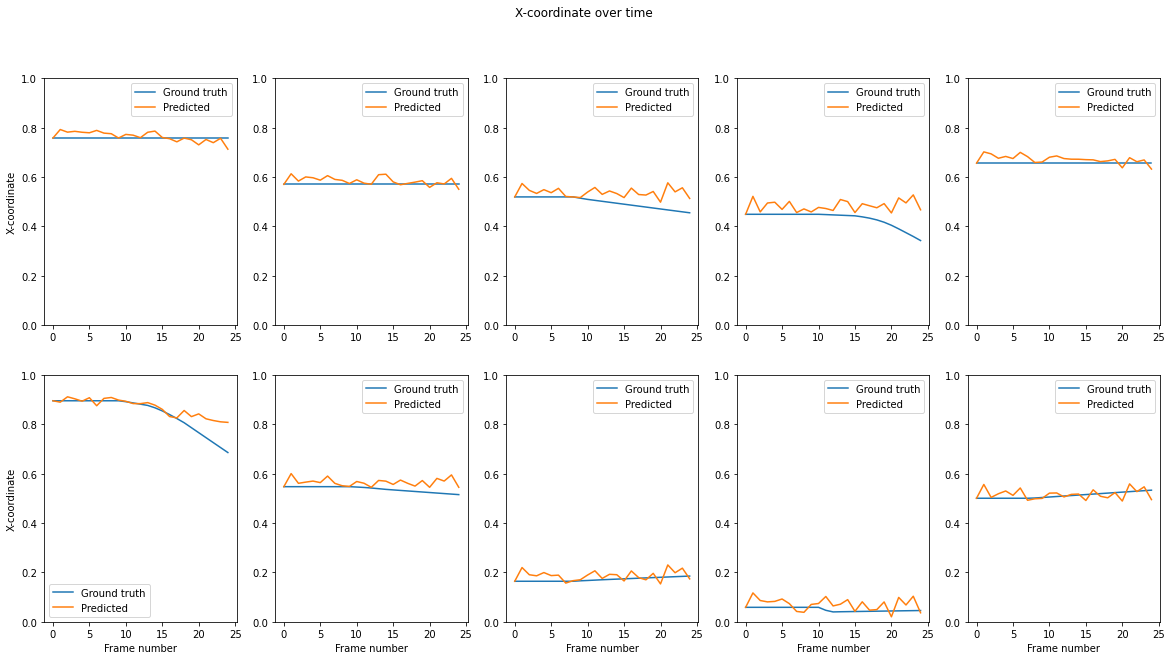

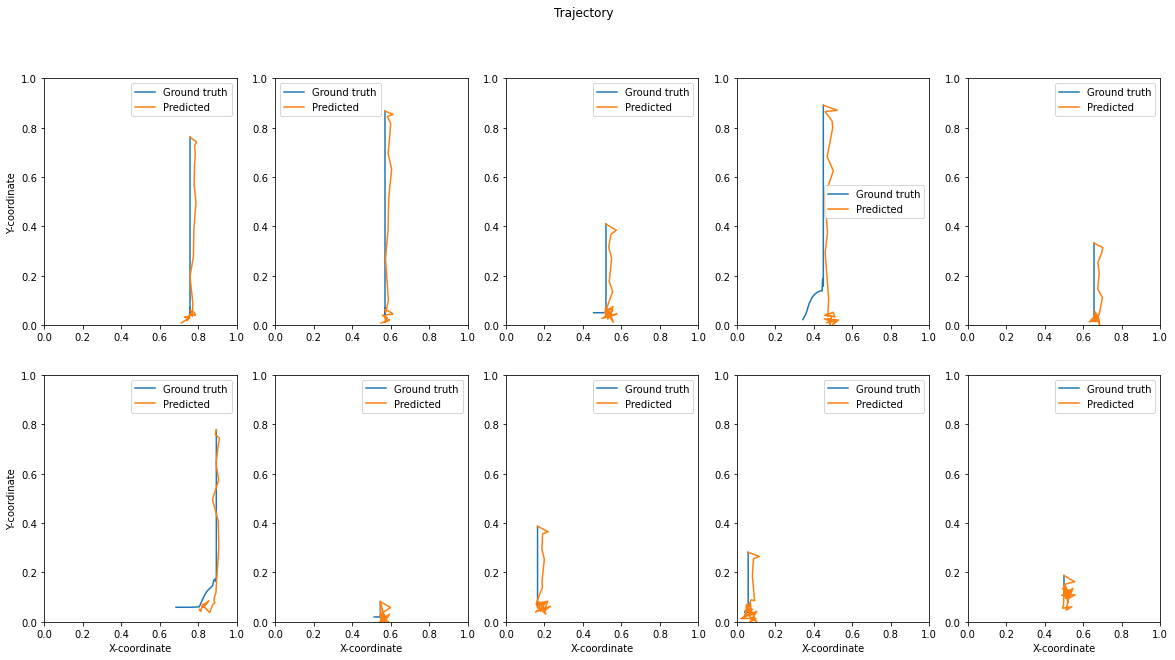

tensor(0.1802, grad_fn=<PowBackward0>)

In [13]:
vanila_rnn_2_layers = VanilaRNN.train_model(num_epochs=200, learning_rate=0.1, train_dataloader=train_dataloader_full, error_threshold=1000, input_dim=9, hidden_dim=best_result_vanilla['hidden_dim'], num_rnns=2, output_dim=48, dropout_prob=best_result_vanilla['dropout_prob'])
VanilaRNN.calculate_loss(vanila_rnn_2_layers, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## GRU

GRU(
  (gru): GRU(9, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=48, bias=True)
)
Epoch 0 complete. Training loss: 19.49489831214305
Epoch 1 complete. Training loss: 5.9806523532024585
Epoch 2 complete. Training loss: 5.381697675562464
Epoch 3 complete. Training loss: 5.212655335984891
Epoch 4 complete. Training loss: 5.133659184182761
Epoch 5 complete. Training loss: 5.0849191326706205
Epoch 6 complete. Training loss: 5.049632742651738
Epoch 7 complete. Training loss: 5.021707624400733
Epoch 8 complete. Training loss: 4.998484139709035
Epoch 9 complete. Training loss: 4.978602395160124
Epoch 10 complete. Training loss: 4.9612656726676505
Epoch 11 complete. Training loss: 4.945953971968265
Epoch 12 complete. Training loss: 4.932299588806927
Epoch 13 complete. Training loss: 4.920026222214801
Epoch 14 complete. Training loss: 4.908917852648301
Epoch 15 complete. Training loss: 4.898801839357475
Epoch 16 complete. Training loss: 4.889536196278641
Epoch 17 complete.

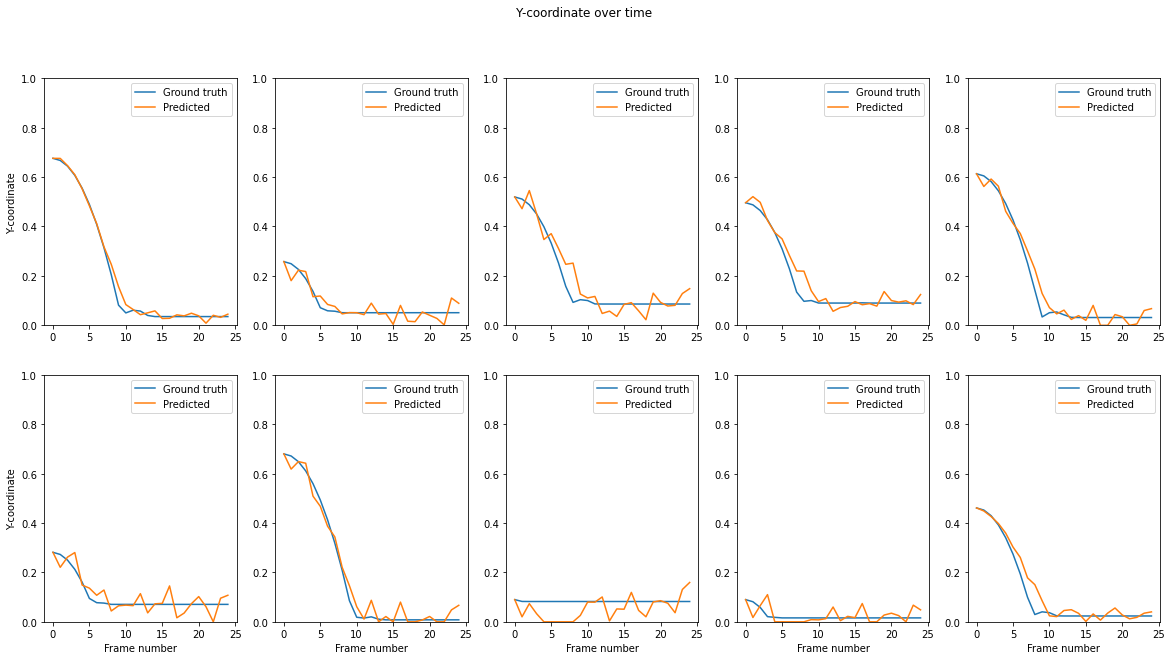

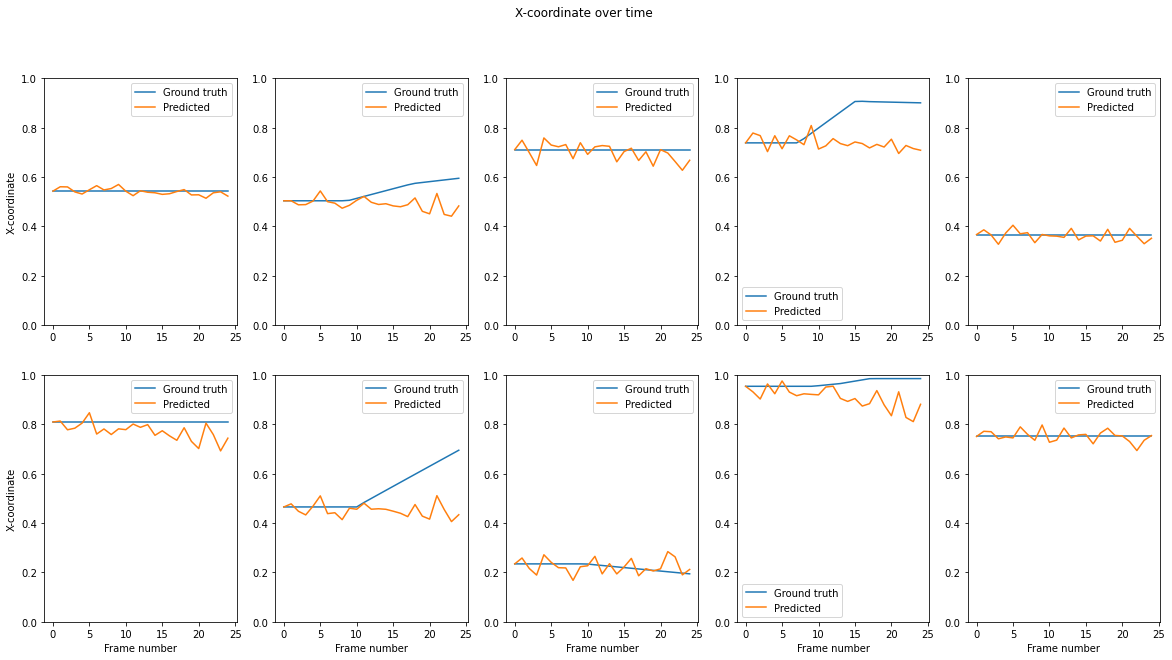

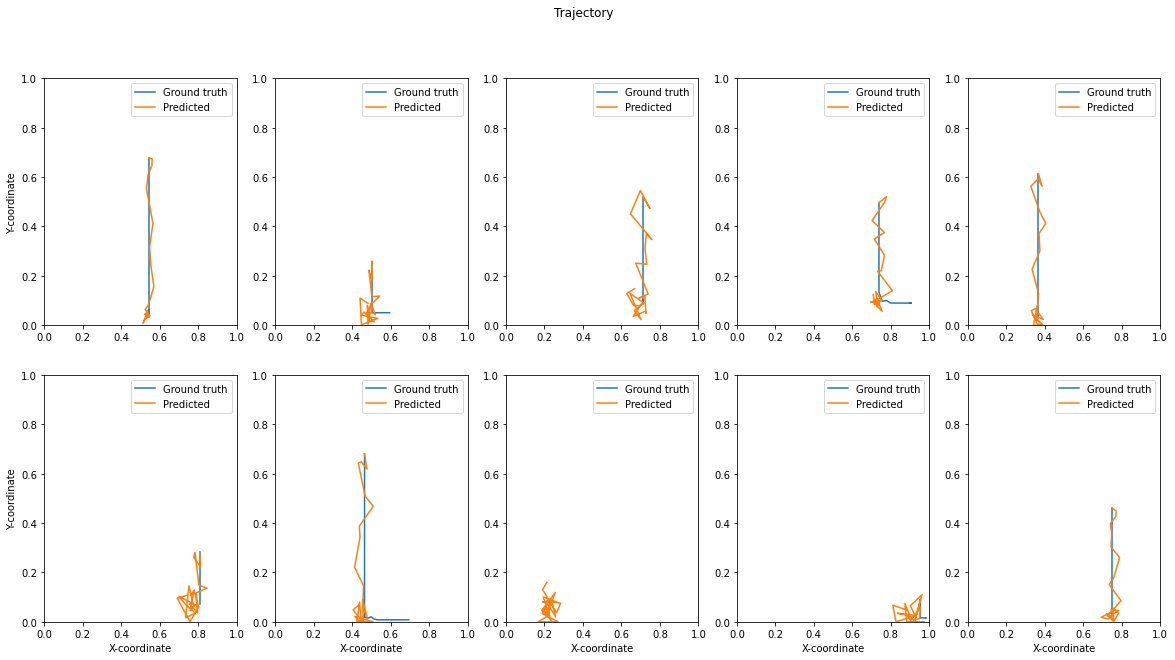

tensor(0.0532, grad_fn=<PowBackward0>)

In [4]:
gru = GRU.train_model(train_dataloader=train_dataloader, error_threshold=1000, input_dim=9, hidden_dim=64, num_rnns=1, output_dim=48, dropout_prob=0)
GRU.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=True)

## LSTM

Calculated loss:  tensor(0.0448, grad_fn=<PowBackward0>)


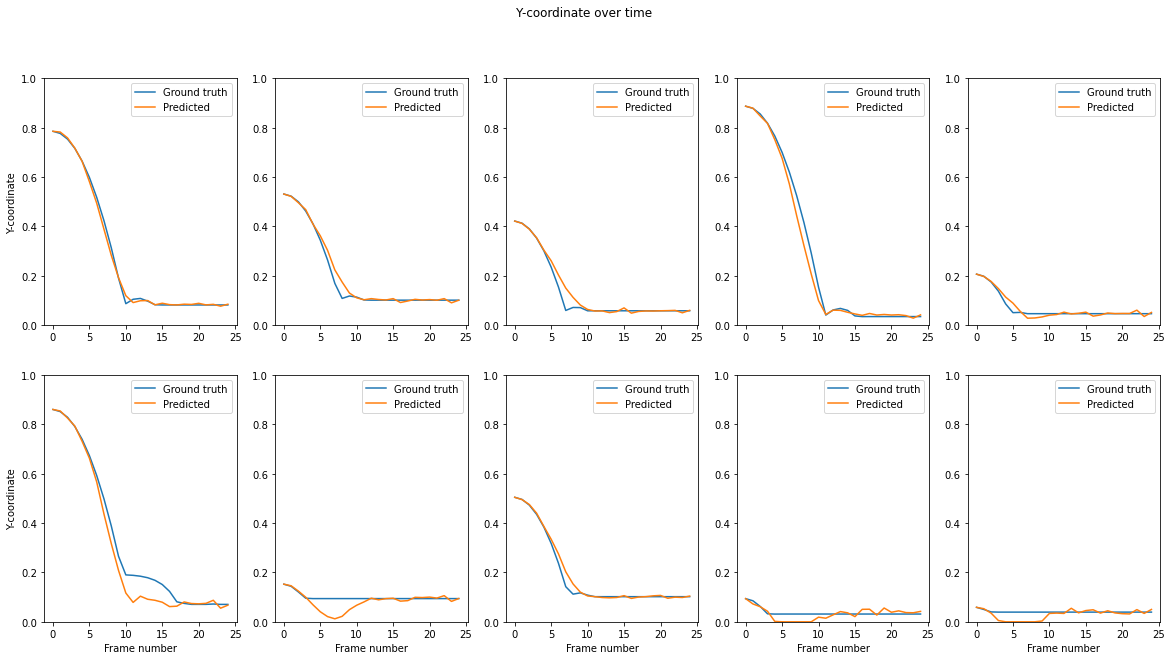

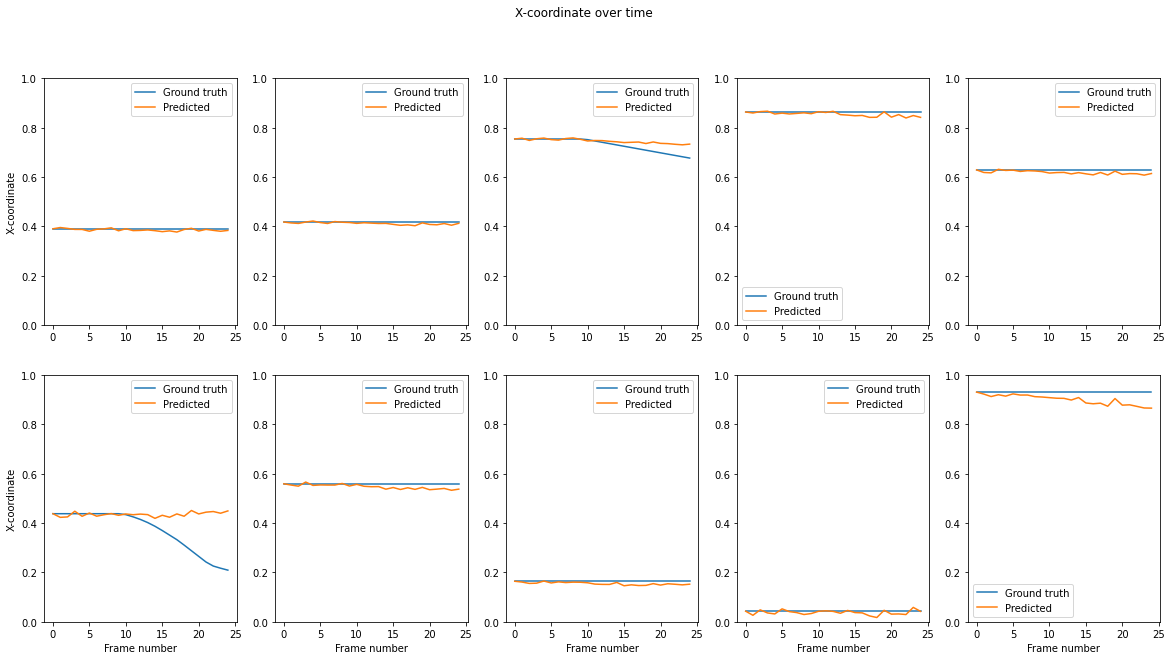

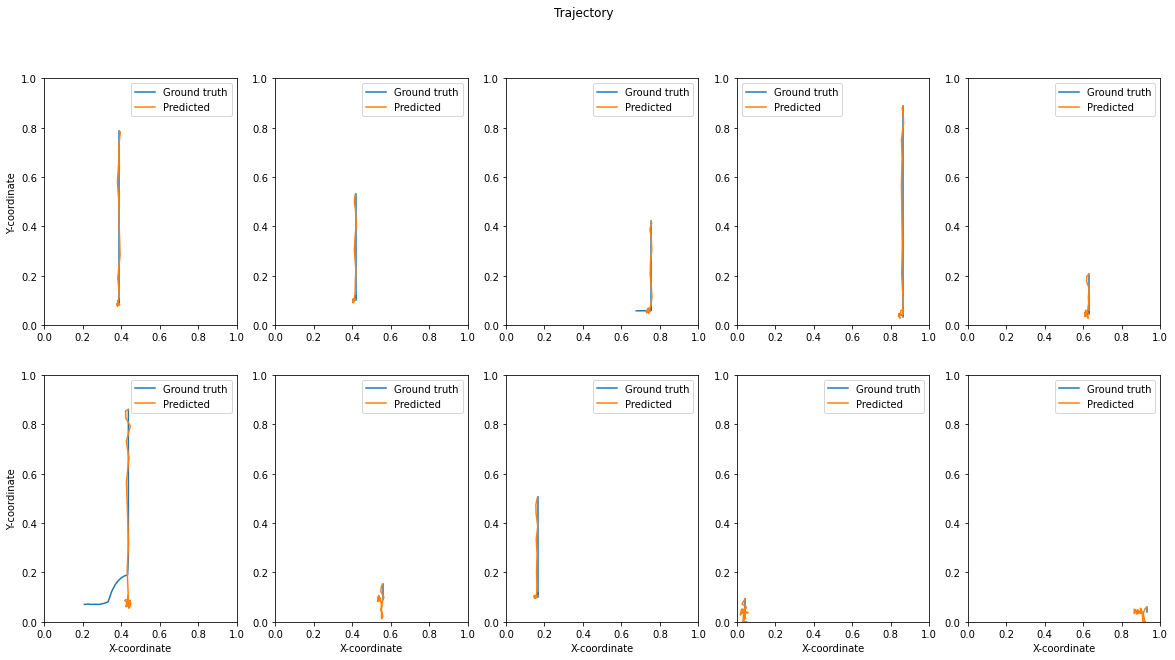

tensor(0.0448, grad_fn=<PowBackward0>)

In [28]:
#lstm = LSTM.train_model(train_dataloader=train_dataloader_full, error_threshold=1000, num_epochs=50, learning_rate=0.03, input_dim=9, hidden_dim=best_result_vanilla['hidden_dim'], num_rnns=1, output_dim=48, dropout_prob=0)
LSTM.calculate_loss(lstm, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## ESN

## Hyperparameter tuning

In [12]:
# dictionary to store the results
results = {}

results_file = 'results_dict_collisions.pkl'

try:
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [14]:
n_units = [150, 200, 250]
lrs = [0.7, 0.9]
srs = [0.1, 0.3, 0.5]
ridges = [1e-2, 0.1]

if 'esn' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['esn'] = []

for units, lr, sr, ridge in tqdm_notebook(product(n_units, lrs, srs, ridges)):
    set_included = False
    for val_set in results['esn']:
        if val_set['units'] == units and val_set['lr'] == lr and val_set['sr'] == sr and val_set['ridge'] == ridge:
            print(f'Value set already included: units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')
            set_included = True
            break

    if set_included:
        continue

    print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

    rpy.set_seed(42)

    esn = ESN.train_model(train_dataloader=train_dataloader, input_dim=9, reservoir_size=units, output_dim=48, leaking_rate=lr, spectral_radius=sr, ridge_param=ridge)
    test_loss = ESN.calculate_loss(esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['esn'].append(
        {
            'units': units,
            'lr': lr,
            'sr': sr,
            'ridge': ridge,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Value set already included: units=150 	 lr=0.7 	 sr=0.1 	 ridge=0.01
Value set already included: units=150 	 lr=0.7 	 sr=0.1 	 ridge=0.1
Value set already included: units=150 	 lr=0.7 	 sr=0.3 	 ridge=0.01
Testing units=150 	 lr=0.7 	 sr=0.3 	 ridge=0.1
'Model-4': Model('Reservoir-4', 'Ridge-4')
Test loss:  0.1044070407613853

Testing units=150 	 lr=0.7 	 sr=0.5 	 ridge=0.01
'Model-5': Model('Reservoir-5', 'Ridge-5')
Test loss:  0.16747075509426798

Testing units=150 	 lr=0.7 	 sr=0.5 	 ridge=0.1
'Model-6': Model('Reservoir-6', 'Ridge-6')
Test loss:  0.0905519699445302

Testing units=150 	 lr=0.9 	 sr=0.1 	 ridge=0.01
'Model-7': Model('Reservoir-7', 'Ridge-7')
Test loss:  0.10352448725301304

Testing units=150 	 lr=0.9 	 sr=0.1 	 ridge=0.1
'Model-8': Model('Reservoir-8', 'Ridge-8')
Test loss:  0.06878337956724144

Testing units=150 	 lr=0.9 	 sr=0.3 	 ridge=0.01
'Model-9': Model('Reservoir-9', 'Ridge-9')
Test loss:  0.09891189124252808

Testing units=150 	 lr=0.9 	 sr=0.3 	 ridge=0.1
'

# Model Training

In [15]:
best_result_esn = min(results['esn'], key=lambda x: x['test_loss'])
best_result_esn

{'units': 200,
 'lr': 0.9,
 'sr': 0.1,
 'ridge': 0.1,
 'test_loss': 0.06202495382587598}

Test loss:  0.07906302324816447


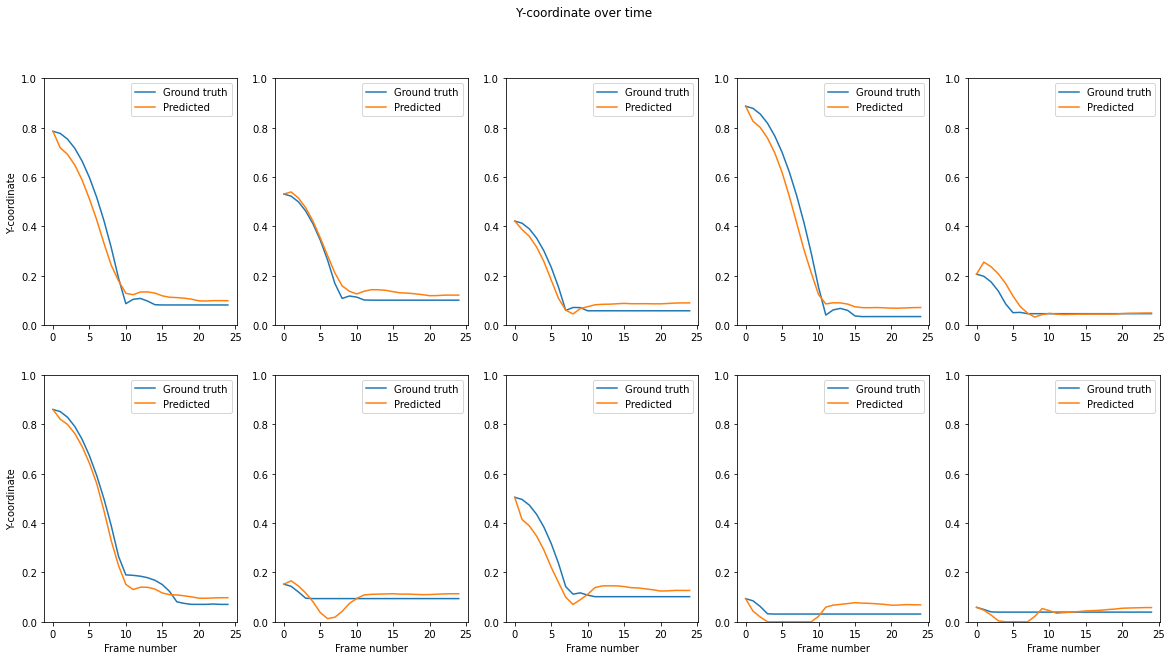

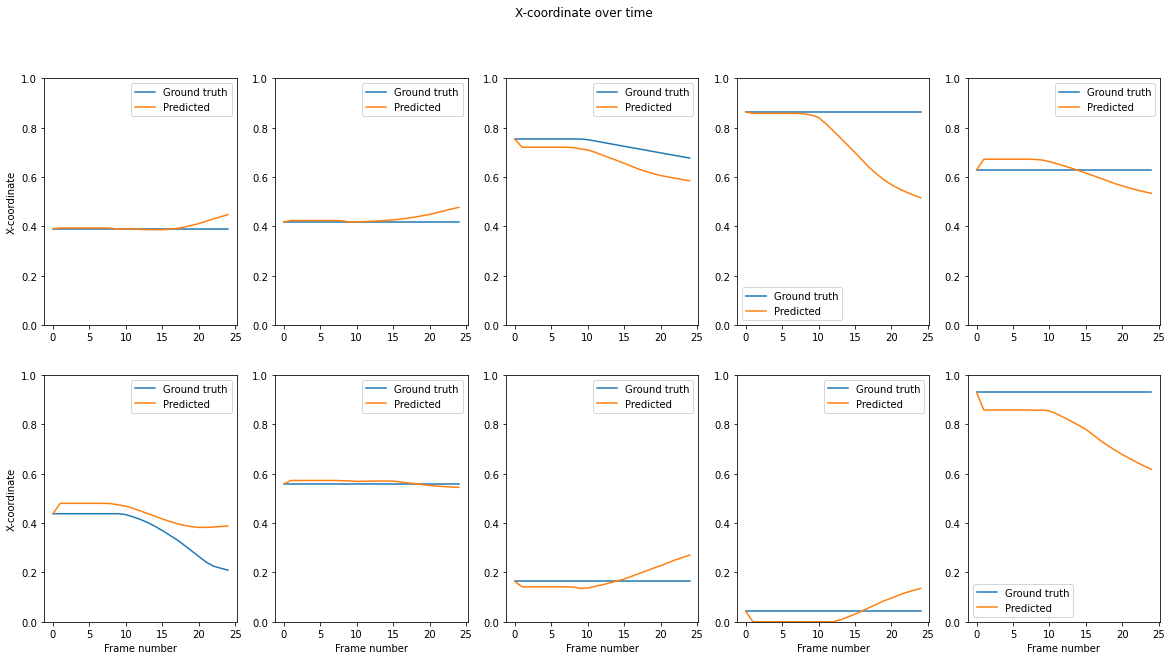

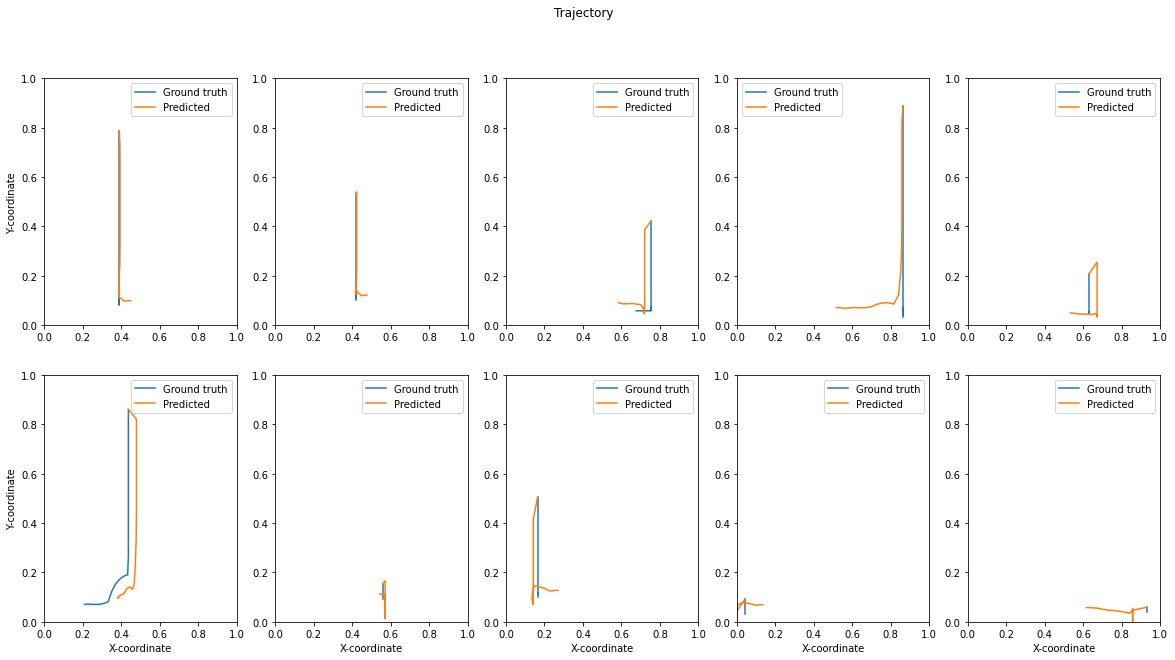

0.07906302324816447

In [29]:
rpy.set_seed(42)

#esn = ESN.train_model(train_dataloader=train_dataloader_full, input_dim=9, reservoir_size=best_result_esn['units'], output_dim=48, leaking_rate=best_result_esn['lr'], spectral_radius=best_result_esn['sr'], ridge_param=best_result_esn['ridge'])
ESN.calculate_loss(esn, mse_esn, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## SeqESN

'Model-4': Model('Input-0', 'Reservoir-1', 'Ridge-1', 'Reservoir-2', 'Ridge-2')
Test loss:  0.1520461784537429


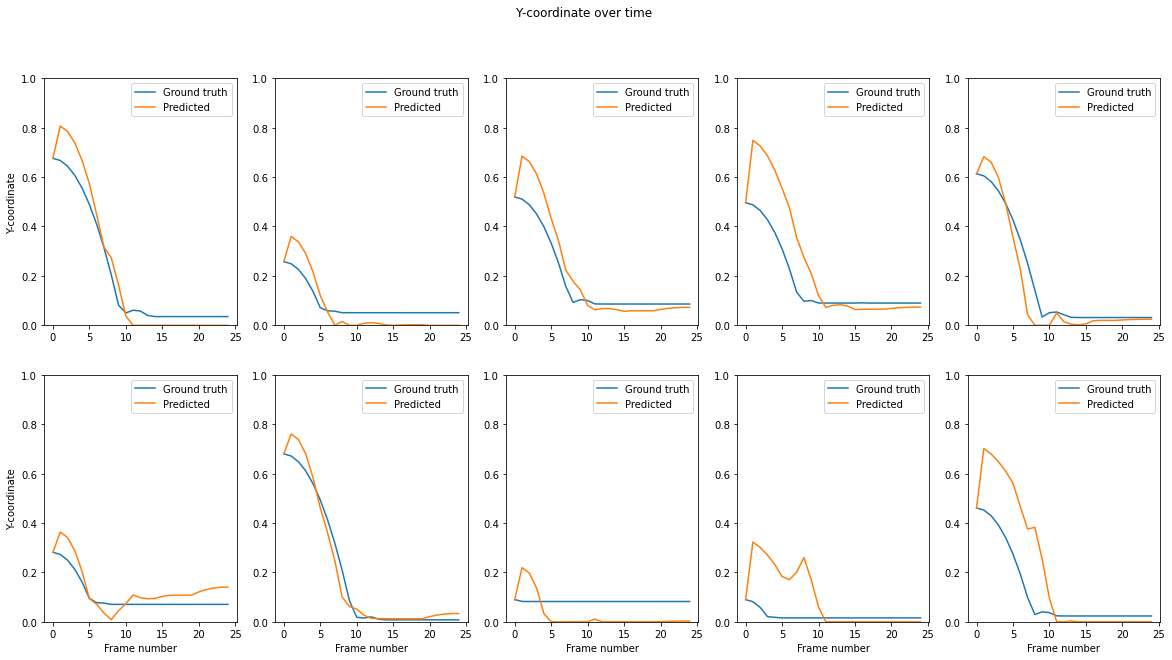

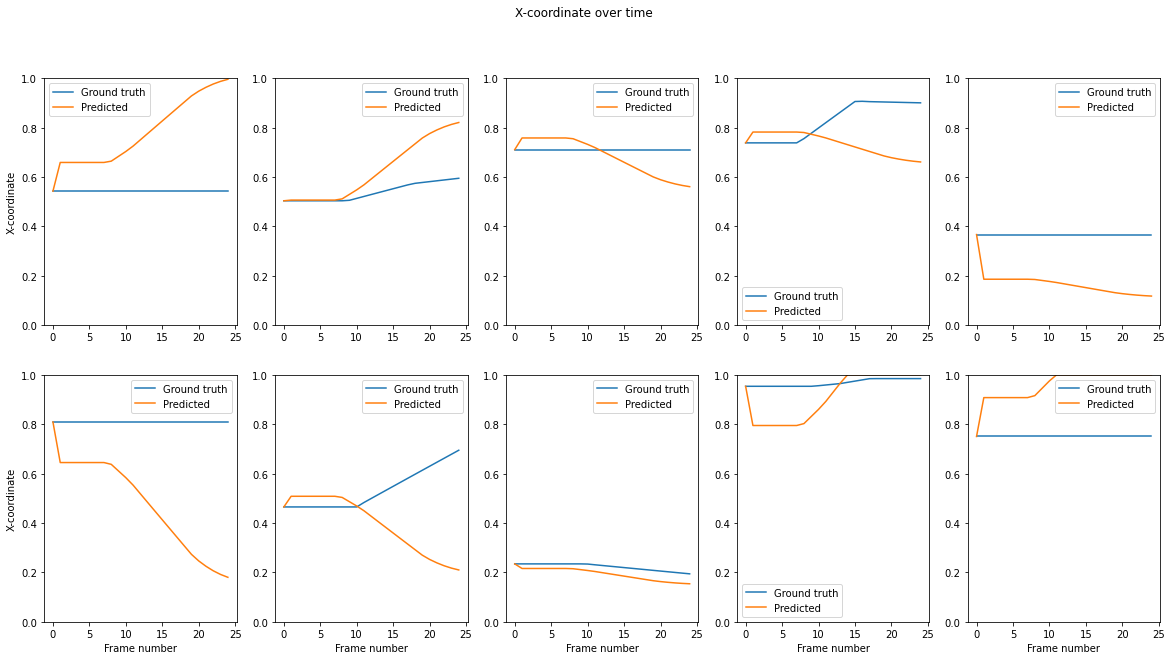

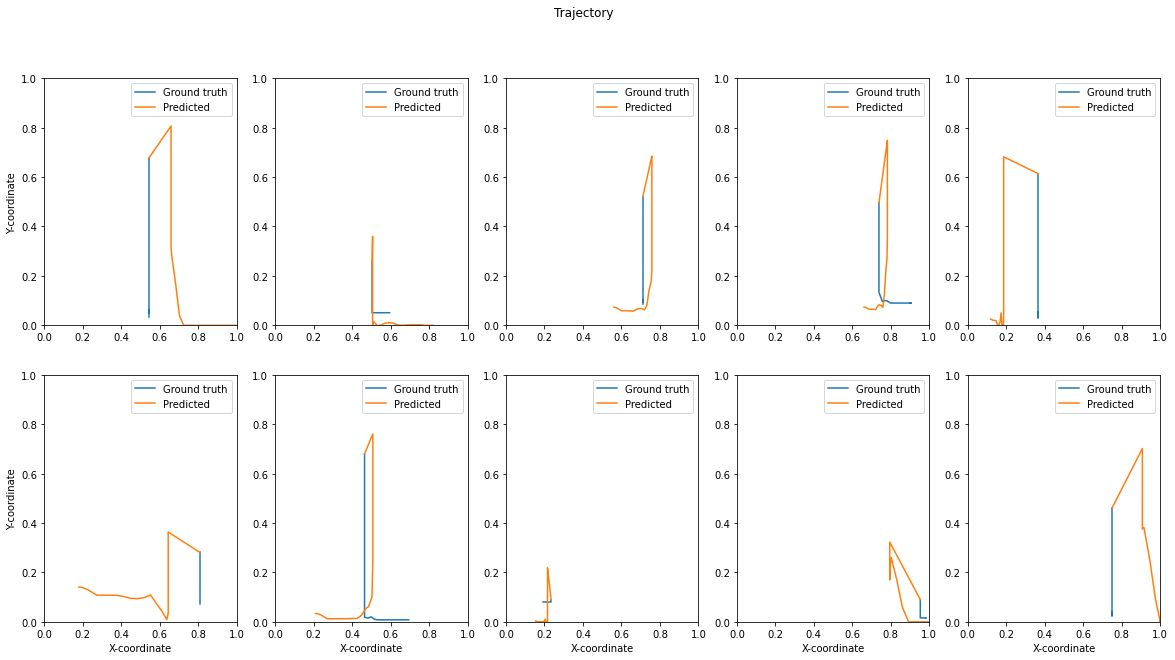

0.1520461784537429

In [13]:
rpy.set_seed(42)

seq_esn = SeqESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
SeqESN.calculate_loss(seq_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## Parallel ESN

'Model-6': Model('Reservoir-4', 'Reservoir-3', 'Concat-0', 'Ridge-3')
Test loss:  0.11200211903731867


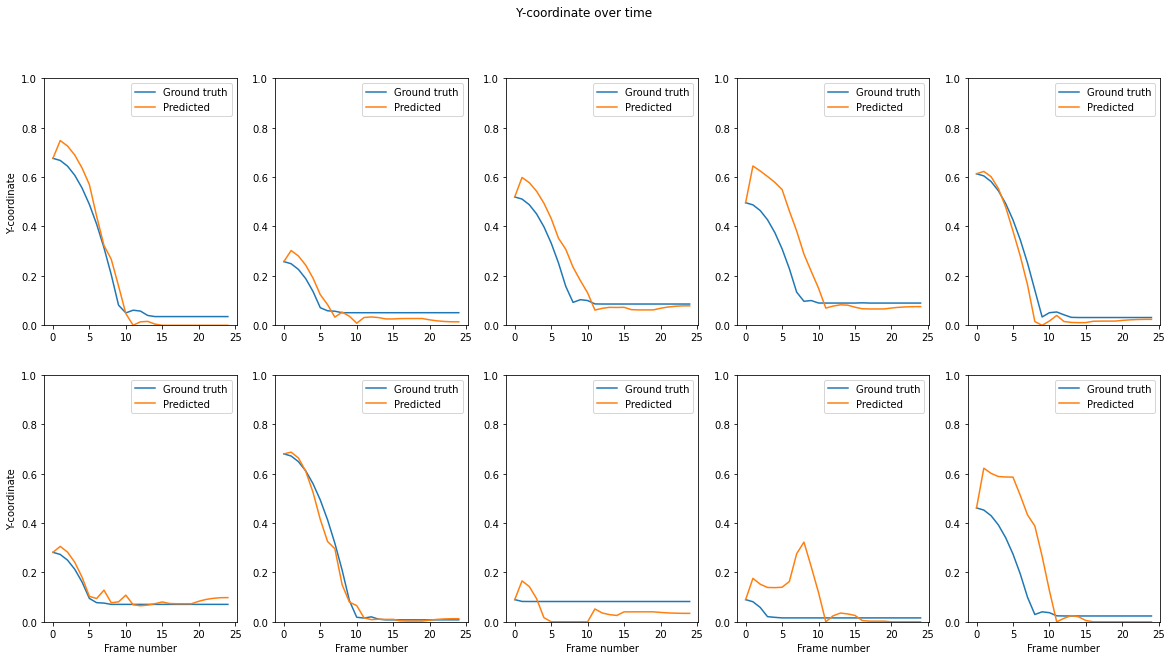

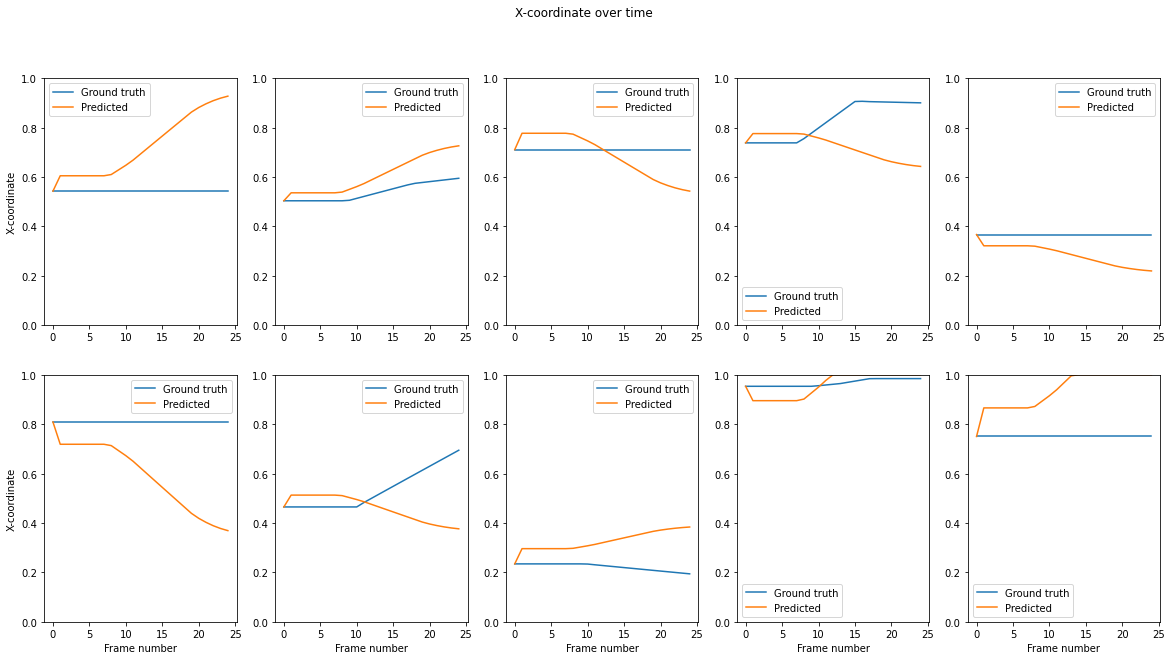

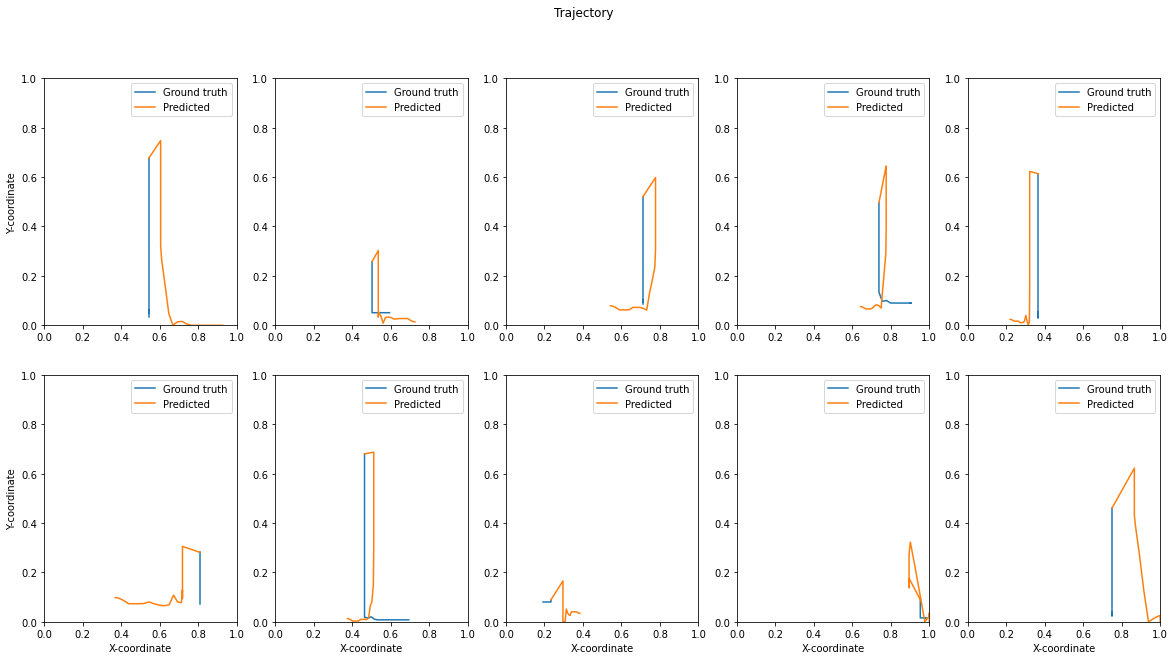

0.11200211903731867

In [14]:
rpy.set_seed(42)

parallel_esn = ParallelESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
ParallelESN.calculate_loss(parallel_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)

## Grouped ESN

'Model-7': Model('Reservoir-5', 'Reservoir-6', 'Concat-1', 'Ridge-4')
Test loss:  0.1315517210888826


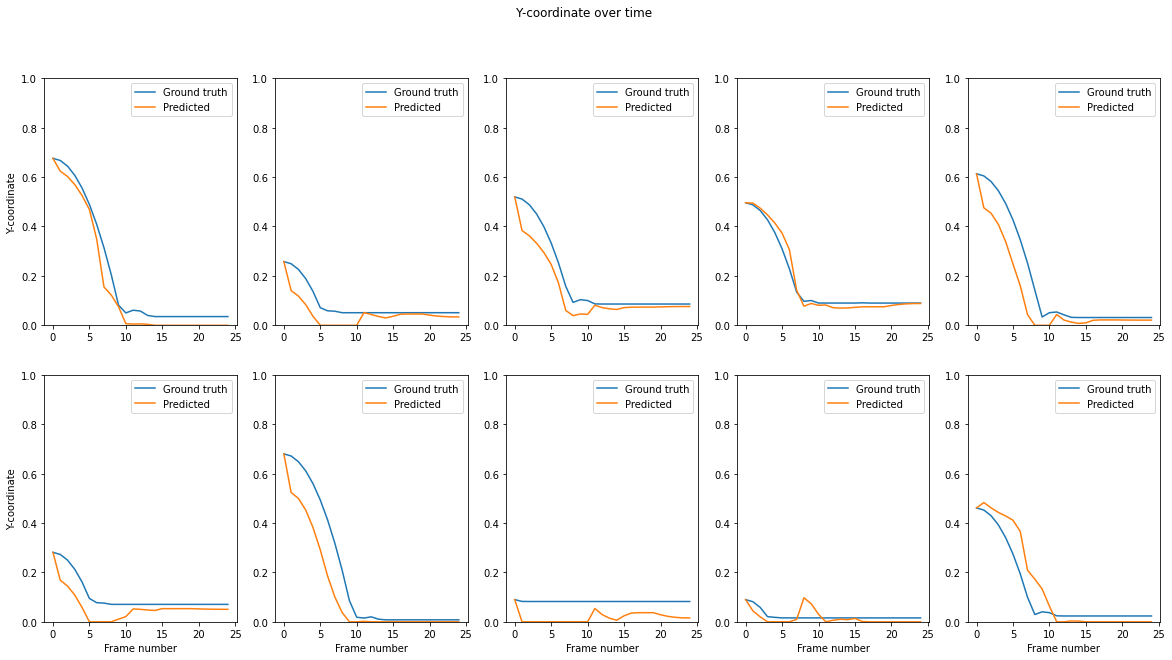

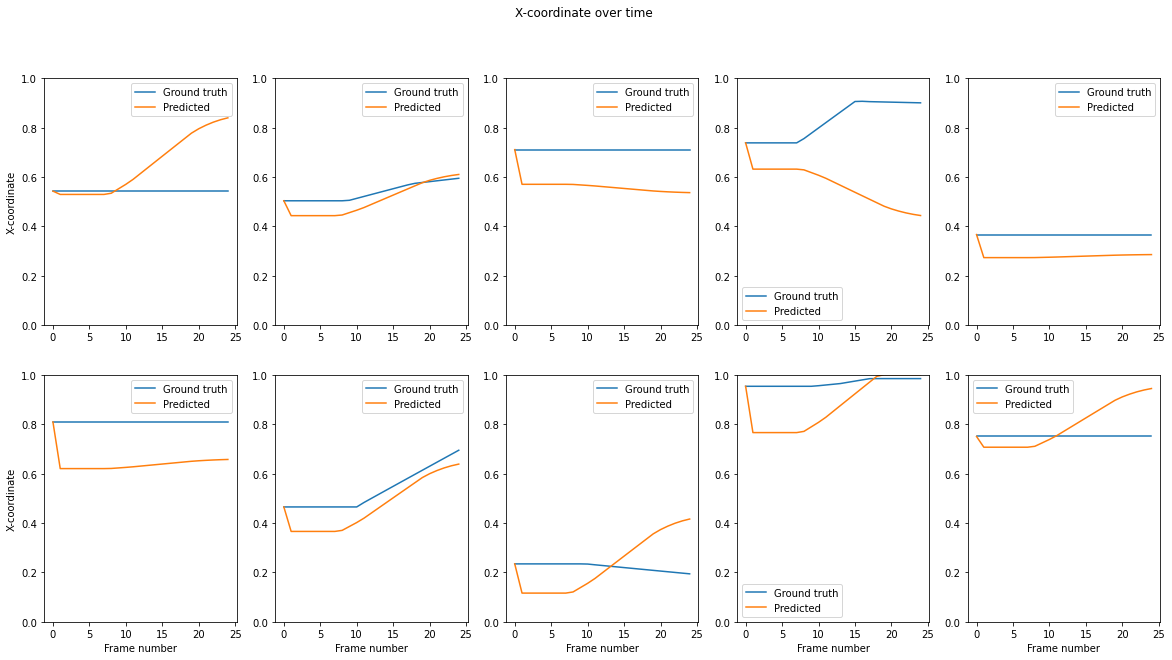

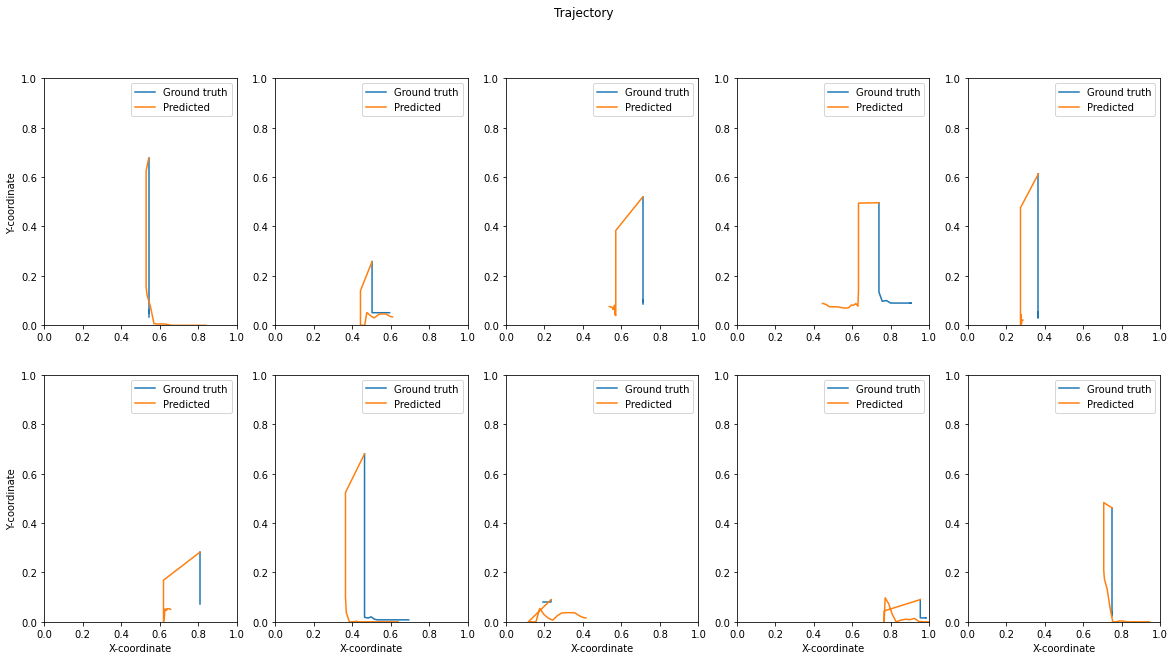

0.1315517210888826

In [15]:
grouped_esn = GroupedESN.train_model(train_dataloader=train_dataloader, input_dim=3, reservoir_size=200, output_dim=48, leaking_rate=0.7, spectral_radius=0.95, ridge_param=0.01, number_of_reservoirs=2)
GroupedESN.calculate_loss(grouped_esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=True)